# Boston housing data

In [1]:
%connect_info

{
  "shell_port": 39665,
  "iopub_port": 52941,
  "stdin_port": 51633,
  "control_port": 60177,
  "hb_port": 54605,
  "ip": "127.0.0.1",
  "key": "3a7a9089-82204423b4e98bc09bca6e5f",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f32ac2ea-1f07-45d3-9491-426393508b84.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


https://mljar.com/blog/feature-importance-xgboost/

## Load libraries

In [2]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

## Get data

Load the boston data

In [3]:
boston = load_boston()

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [7]:
df['target'] = boston.target

In [8]:
df['CHAS'] = df.CHAS.astype('boolean')

## Gradient boosting model

Setup the data for the model

In [9]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Train the model

In [10]:
xgb = XGBRegressor(n_estimators=100, importance_type='gain')
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Feature importance

In [11]:
importance = pd.Series(
    data=xgb.feature_importances_,
    index=boston.feature_names
).to_frame(name='importance').reset_index().rename(
    columns={'index': 'feature'})

<AxesSubplot:xlabel='importance', ylabel='feature'>

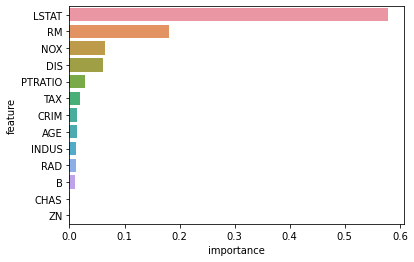

In [12]:
sns.barplot(
    x='importance', y='feature', data=importance,
    order=importance.sort_values(
        'importance', ascending=False).feature)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

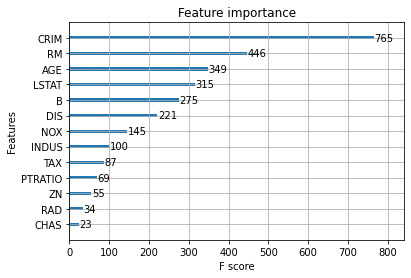

In [13]:
plot_importance(xgb)

In [14]:
perm_importance_dict = permutation_importance(xgb, X_train, y_train)

In [15]:
perm_importance = pd.Series(
    data=perm_importance_dict['importances_mean'],
    index=boston.feature_names
).to_frame(name='importance').reset_index().rename(
    columns={'index': 'feature'})

<AxesSubplot:xlabel='importance', ylabel='feature'>

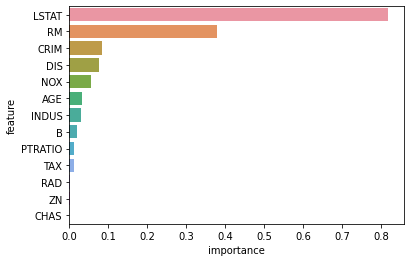

In [16]:
sns.barplot(
    x='importance', y='feature', data=perm_importance,
    order=perm_importance.sort_values(
        'importance', ascending=False).feature)

In [17]:
perm_importance_dict['importances_mean']

array([8.45283991e-02, 2.40449548e-04, 2.88925944e-02, 9.72111896e-05,
       5.59271118e-02, 3.78910909e-01, 3.24181954e-02, 7.60619398e-02,
       1.14075582e-03, 1.13764832e-02, 1.19565515e-02, 2.03021826e-02,
       8.18021566e-01])

In [18]:
y_predict = xgb.predict(X_test)

In [19]:
r2_score(y_test, y_predict)

0.8563261320300065

## Intepretable models

In [20]:
from interpret import show
from interpret.data import Marginal

In [21]:
marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
show(marginal)

<!-- http://127.0.0.1:7001/139933903006448/ -->

In [22]:
from interpret.glassbox import ExplainableBoostingRegressor

In [23]:
ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS',
                                            'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                                            'TAX', 'PTRATIO', 'B', 'LSTAT'],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'categorical',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous'])

In [24]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7001/139932476843248/ -->

In [25]:
from interpret.perf import RegressionPerf

In [26]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(
    X_test, y_test, name='EBM')

In [27]:
show(ebm_perf)

<!-- http://127.0.0.1:7001/139933768341296/ -->